In [5]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
from astropy.visualization import ZScaleInterval, LogStretch
from scipy.interpolate import interp1d
import matplotlib
from astropy.convolution import convolve, Box1DKernel
from scipy.stats import sigmaclip
from scipy.ndimage import median_filter
from copy import deepcopy


# Setting up input information
Enter in the necessary information in the below cell and then you should be able to run the rest of the cells without changing things.

# Options:
combination_method:  'median' or 'sum'
 - This defines how to combine the spectra
 
nan_flux_filler:  float
 - This tells the code what to replace nan's in the final combined spectrum if you don't want nans
 
nan_flux_filler:  float
 - This tells the code what to replace nan's in the final combined variance if you don't want nans
 
# Base_filename:
If your filenames are 'S20220915S0034_2x4_red001.fits, S20220915S0034_2x4_red002.fits, etc.', you should put in a base_filename of 'S20220915S0034_2x4'.  It would be everything up to red/blue00N.fits, the code will generate the rest and loop through them

# Input Arcs:
You should input the filenames of the reduced/calibration arcs that you used for your wavelength solutions.

In [9]:
base_filename = 'S20220915S0034_2x4'
red_arc_filename = 'arcname_red001_arc.fits'
blue_arc_filename = 'arcname_blue001_arc.fits'
output_filename_base = 'My_star_name'
object_number = 0
N_red_exposures = 3
N_blue_exposures = 3
filepath = '.'
combination_method = 'median'
nan_flux_filler = 0.
nan_var_filler = 1.e12

read in all of the files and set up the formatting to easily combine them

In [ ]:
def calculate_new_wavelength(data, arc, camera='blue'):
    if camera == 'blue':
        m_ref = 80
        npix = 4096
        m_base = 64 # i + 64
    elif camera == 'red':
        m_ref = 50
        npix = 6144
        m_base = 33 # i + 33
        
    binning = npix//data[1].data.shape[1]
    orders = data[1].data.shape[0]

    if binning == 1:
        return
    elif binning == 2:
        clock_npix = 1
    elif binnin == 4:
        clock_npix = 3
                
    arc_wavemod = arc[4].data
    new_wavelengths = np.zeros(data[4].data.shape)
            
    for order in range(orders):
        
        m = order + m_base
        yprimes = np.arange(npix).reshape(int(npix/binning), binning).mean(axis=1)
        yprimes[yprimes < 2048] -= clock_npix
        yprimes[yprimes >= 2048] += clock_npix
        
        poly_w_model = np.poly1d([np.poly1d(arc_wavemod[i,:])((m_ref/m)-1) for i in range(len(arc_wavemod[:,0]))])
        
        new_wavelengths[order, :] = poly_w_model(yprimes - npix//2)
    
    data[4].data = new_wavelengths

In [ ]:
def interpolateAndCombine(data, oversample=2):
    """
    Combine the independent orders from the input ADs into a single,
    over-sampled spectrum.

    The wavelength scale of the output is determined by finding the
    wavelength range of the input, and generating a new
    wavelength sampling in accordance with the ``scale`` and
    ``oversample`` parameters.

    The output spectrum is constructed as follows:

    - A blank spectrum, corresponding to the new wavelength scale, is
      initialised;
    - For each order of the input AstroData object:

        - The spectrum order is re-gridded onto the output wavelength scale;
        - The re-gridded order is averaged with the final output spectrum
          to form a new output spectrum.

      This process continues until all orders have been averaged into the
      final output spectrum.

    Note that the un-interpolated data is kept - the interpolated data
    is appended to the end of the file as a new extension.

    Parameters
    ----------
    oversample : int or float
        The factor by which to (approximately) oversample the final output
        spectrum, as compared to the input spectral orders. Defaults to 2.
    """

    # Determine the wavelength bounds of the file
    min_wavl, max_wavl = np.min(data[4].data), np.max(data[4].data)
    logspacing = np.median(
        np.log(data[4].data[:, 1:]) - np.log(data[4].data[:, :-1])
    )
    # Form a new wavelength scale based on these extremes
    wavl_grid = np.exp(
        np.linspace(np.log(min_wavl), np.log(max_wavl),
                    num=int(
                        (np.log(max_wavl) - np.log(min_wavl)) /
                        (logspacing / float(oversample))
                    ))
    )


    # Create a final spectrum and (inverse) variance to match
    # (One plane per object)
    no_obj = data[1].shape[-1]
    spec_final = np.zeros(wavl_grid.shape + (no_obj, ))
    var_final = np.inf * np.ones(wavl_grid.shape + (no_obj, ))
    
    data[2].data[data[2].data == 0] = 1.e12 
    data[2].data[:,0:2,:] = 1.e12 
    data[2].data[:,-2:,:] = 1.e12 

    # Loop over each input order, making the output spectrum the
    # result of the weighted average of itself and the order
    # spectrum
    for order in range(data[1].shape[0]):
        for ob in range(data[1].shape[-1]):
            flux_for_adding = np.interp(wavl_grid,
                                        data[4].data[order],
                                        data[1].data[order, :, ob],
                                        left=0, right=0)
            ivar_for_adding = np.interp(wavl_grid,
                                        data[4].data[order],
                                        1.0 /
                                        data[2].data[order, :, ob],
                                        left=0, right=0)
            spec_comp, ivar_comp = np.ma.average(
                np.asarray([spec_final[:, ob], flux_for_adding]),
                weights=np.asarray([1.0 / var_final[:, ob],
                                    ivar_for_adding]),
                returned=True, axis=0,
            )
            spec_final[:, ob] = deepcopy(spec_comp)
            var_final[:, ob] = deepcopy(1.0 / ivar_comp)


    return spec_final, var_final, wavl_grid

In [3]:
red_arc = fits.open(f'{filepath}/{red_arc_filename}')
blue_arc = fits.open(f'{filepath}/{blue_arc_filename}')


with fits.open(f'{filepath}/{base_filename}_red001_formattedOutput.fits') as star_red_add:
    calculate_new_wavelength(star_red_add, red_arc, camera='red')
    spec, var, wave = interpolateAndCombine(star_red_add, oversample=1)
    star_wave_red = wave

data_arr = np.zeros((len(star_wave_red),N_red_exposures))
var_arr = np.zeros((len(star_wave_red),N_red_exposures))
for i in range(N_red_exposures):
    with fits.open(f'{filepath}/{base_filename}_red00{i+1}_formattedOutput.fits') as star_red_add:
        
        calculate_new_wavelength(star_red_add, red_arc, camera='red')
        spec, var, wave = interpolateAndCombine(star_red_add, oversample=1)

        data_arr[:,i] = spec[:,object_number]
        var_arr[:,i] = var[:,object_number]
        
star_red_arr = data_arr
star_red_var_arr = var_arr

with fits.open(f'{filepath}/{base_filename}_blue001_formattedOutput.fits') as star_blue_add:
    calculate_new_wavelength(star_blue_add, blue_arc, camera='blue')
    spec, var, wave = interpolateAndCombine(star_blue_add, oversample=1)
    star_wave_blue = wave

data_arr = np.zeros((len(star_wave_blue),N_blue_exposures))
var_arr = np.zeros((len(star_wave_blue),N_blue_exposures))
for i in range(N_blue_exposures):
    with fits.open(f'{filepath}/{base_filename}_blue00{i+1}_formattedOutput.fits') as star_blue_add:
        
        calculate_new_wavelength(star_blue_add, blue_arc, camera='blue')
        spec, var, wave = interpolateAndCombine(star_blue_add, oversample=1)

        data_arr[:,i] = spec[:,object_number]
        var_arr[:,i] = var[:,object_number]
        
star_blue_arr = data_arr
star_blue_var_arr = var_arr


Combine the spectra

In [ ]:
star_blue_wave_comb = star_wave_blue
star_red_wave_comb = star_wave_red

if combination_method == 'median':
    star_blue_comb = np.nanmedian(star_blue_arr,axis=1)
    star_blue_var_comb = np.nanmedian(star_blue_var_arr, axis=1)/N_blue_exposures

    star_red_comb = np.nanmedian(star_red_arr,axis=1)
    star_red_var_comb = np.nanmedian(star_red_var_arr, axis=1)/N_red_exposures

    
elif combination_method == 'sum':
    star_blue_comb = np.nansum(star_blue_arr,axis=1)
    star_blue_var_comb = np.nansum(star_blue_var_arr, axis=1)

    star_red_comb = np.nansum(star_red_arr,axis=1)
    star_red_var_comb = np.nansum(star_red_var_arr, axis=1)

In [ ]:
star_blue_comb[~np.isfinite(star_blue_comb)|~np.isfinite(star_blue_var_comb)] = nan_flux_filler
star_blue_var_comb[~np.isfinite(star_blue_comb)|~np.isfinite(star_blue_var_comb)] = nan_var_filler

star_red_comb[~np.isfinite(star_red_comb)|~np.isfinite(star_red_var_comb)] = nan_flux_filler
star_red_var_comb[~np.isfinite(star_red_comb)|~np.isfinite(star_red_var_comb)] = nan_var_filler



In [ ]:
with open(f'{output_filename_base}_blue.txt','w') as file:
    print('# wavelength flux variance', file=file)
    for wave, flux, var in zip(star_blue_wave_comb, star_blue_comb, star_blue_var_comb):
        print(wave, flux, var, file=file)
        
with open(f'{output_filename_base}_red.txt','w') as file:
    print('# wavelength flux variance', file=file)
    for wave, flux, var in zip(star_red_wave_comb, star_red_comb, star_red_var_comb):
        print(wave, flux, var, file=file)

# Plotting options below for looking at these spectra

In [5]:
def datavarplot(x, y, var, extension=1, xrange=[3500, 10600], yrange=[-100, 4000], scale_factor=1.0):

    fig = plt.figure(figsize = (16,6))

    ax = fig.add_subplot(111)


    if extension is None:
        ax.plot(x, y, c='k', lw=2, label='flux')
        ax.plot(x, var, c='r', lw=2, label='var')
    else:
        ax.plot(x, y[:,extension], c='k', lw=2, label='flux')
        ax.plot(x, var[:,extension], c='r', lw=2, label='var')
#     ax.plot(cand_wave_blue, cand_blue, c='b', lw=2, label='Cand Blue')
#     ax.plot(mem_wave_blue, mem_blue*scale_factor, c='turquoise', lw=2, label='Mem Blue')



    # ax.plot(xvals, function(xvals), c='b')


    # Label the x and y axes
    ax.set_xlabel(r'Wavelength ($\rm \AA$, air)', fontsize=16)
    ax.set_ylabel(r'Flat Corrected Flux', fontsize=16)
    # ax.set_yticks([1 - offset for offset in offsets])
    ax.tick_params(axis='both', direction='in', labelsize=16)

    # Make a legend and set some of my prefered styles for the legend
    # leg = ax.legend(loc=0, numpoints=1, framealpha=0.5, prop={'size':14})
    # leg.get_frame().set_linewidth(0.0)

    # Format the numbers on the xaxis to make them people friendly
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_xaxis().get_major_formatter().set_scientific(False)


    ax.set_xlim([3400, 10800])

    ax.set_xlim(xrange)
    ax.set_ylim(yrange)






    # Write the star's information in the title so you can remember what you are looking at
    # ax.set_title(f'{star.telescope}, {star.field}, {star.apogee_id}', fontsize = 12)

    plt.tight_layout()
    plt.savefig('mem_cand_plot.pdf')
    plt.show()
    plt.close(fig)




In [6]:
def datavarplot2(x, y, var, xrange=[3500, 10600], yrange=[-100, 4000], scale_factor=1.0):

    fig = plt.figure(figsize = (16,6))

    ax = fig.add_subplot(111)



    ax.plot(x, y, c='k', lw=2, label='flux')
    ax.plot(x, var, c='r', lw=2, label='var')
#     ax.plot(cand_wave_blue, cand_blue, c='b', lw=2, label='Cand Blue')
#     ax.plot(mem_wave_blue, mem_blue*scale_factor, c='turquoise', lw=2, label='Mem Blue')



    # ax.plot(xvals, function(xvals), c='b')


    # Label the x and y axes
    ax.set_xlabel(r'Wavelength ($\rm \AA$, air)', fontsize=16)
    ax.set_ylabel(r'Flat Corrected Flux', fontsize=16)
    # ax.set_yticks([1 - offset for offset in offsets])
    ax.tick_params(axis='both', direction='in', labelsize=16)

    # Make a legend and set some of my prefered styles for the legend
    # leg = ax.legend(loc=0, numpoints=1, framealpha=0.5, prop={'size':14})
    # leg.get_frame().set_linewidth(0.0)

    # Format the numbers on the xaxis to make them people friendly
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_xaxis().get_major_formatter().set_scientific(False)


    ax.set_xlim([3400, 10800])

    ax.set_xlim(xrange)
    ax.set_ylim(yrange)






    # Write the star's information in the title so you can remember what you are looking at
    # ax.set_title(f'{star.telescope}, {star.field}, {star.apogee_id}', fontsize = 12)

    plt.tight_layout()
    plt.savefig('mem_cand_plot.pdf')
    plt.show()
    plt.close(fig)





In [7]:
def snrplot(x, y, var, extension=1, xrange=[3500, 10600], yrange=[-0, 100], scale_factor=1.0):

    fig = plt.figure(figsize = (16,6))

    ax = fig.add_subplot(111)


    if extension is None:
        ax.plot(x, y/np.sqrt(var), c='k', lw=2, label='snr')
    else:
        ax.plot(x, y[:,extension]/np.sqrt(var[:,extension]), c='k', lw=2, label='snr')
#     ax.plot(x, var[:,extension], c='r', lw=2, label='var')
#     ax.plot(cand_wave_blue, cand_blue, c='b', lw=2, label='Cand Blue')
#     ax.plot(mem_wave_blue, mem_blue*scale_factor, c='turquoise', lw=2, label='Mem Blue')



    # ax.plot(xvals, function(xvals), c='b')


    # Label the x and y axes
    ax.set_xlabel(r'Wavelength ($\rm \AA$, air)', fontsize=16)
    ax.set_ylabel(r'S/N', fontsize=16)
    # ax.set_yticks([1 - offset for offset in offsets])
    ax.tick_params(axis='both', direction='in', labelsize=16)

    # Make a legend and set some of my prefered styles for the legend
    # leg = ax.legend(loc=0, numpoints=1, framealpha=0.5, prop={'size':14})
    # leg.get_frame().set_linewidth(0.0)

    # Format the numbers on the xaxis to make them people friendly
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_xaxis().get_major_formatter().set_scientific(False)


    ax.set_xlim([3400, 10800])

    ax.set_xlim(xrange)
    ax.set_ylim(yrange)






    # Write the star's information in the title so you can remember what you are looking at
    # ax.set_title(f'{star.telescope}, {star.field}, {star.apogee_id}', fontsize = 12)

    plt.tight_layout()
    plt.savefig('mem_cand_plot.pdf')
    plt.show()
    plt.close(fig)





In [8]:
def medfil_snrplot(x, y, var, extension=1, xrange=[3500, 10600], yrange=[-0, 100], scale_factor=1.0, size=11):

    fig = plt.figure(figsize = (16,6))

    ax = fig.add_subplot(111)


    if extension is None:
        ax.plot(x, median_filter(y, size=size)/np.sqrt(median_filter(var, size=size)), c='k', lw=2, label='snr')
    else:
        ax.plot(x, median_filter(y[:,extension], size=size)/np.sqrt(median_filter(var[:,extension], size=size)), c='k', lw=2, label='snr')
#     ax.plot(x, var[:,extension], c='r', lw=2, label='var')
#     ax.plot(cand_wave_blue, cand_blue, c='b', lw=2, label='Cand Blue')
#     ax.plot(mem_wave_blue, mem_blue*scale_factor, c='turquoise', lw=2, label='Mem Blue')



    # ax.plot(xvals, function(xvals), c='b')


    # Label the x and y axes
    ax.set_xlabel(r'Wavelength ($\rm \AA$, air)', fontsize=16)
    ax.set_ylabel(r'Flat Corrected Flux', fontsize=16)
    # ax.set_yticks([1 - offset for offset in offsets])
    ax.tick_params(axis='both', direction='in', labelsize=16)

    # Make a legend and set some of my prefered styles for the legend
    # leg = ax.legend(loc=0, numpoints=1, framealpha=0.5, prop={'size':14})
    # leg.get_frame().set_linewidth(0.0)

    # Format the numbers on the xaxis to make them people friendly
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_xaxis().get_major_formatter().set_scientific(False)


    ax.set_xlim([3400, 10800])

    ax.set_xlim(xrange)
    ax.set_ylim(yrange)






    # Write the star's information in the title so you can remember what you are looking at
    # ax.set_title(f'{star.telescope}, {star.field}, {star.apogee_id}', fontsize = 12)

    plt.tight_layout()
    plt.savefig('mem_cand_plot.pdf')
    plt.show()
    plt.close(fig)






# Plot Individual spectra and variance

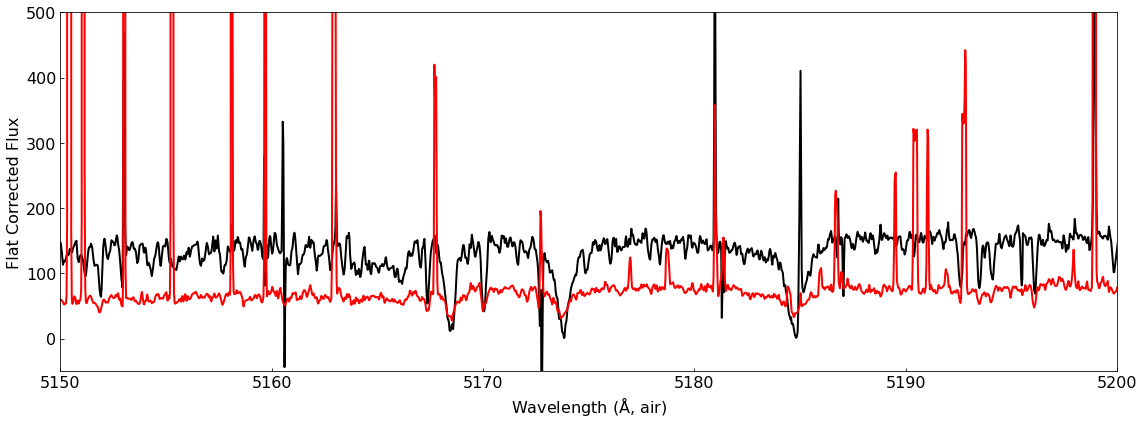

In [9]:
datavarplot(star_wave_blue, star_blue_arr, star_blue_var_arr, xrange=[5150, 5200], yrange=[-50, 500], extension=1)

# Plot S/N of an individual spectrum

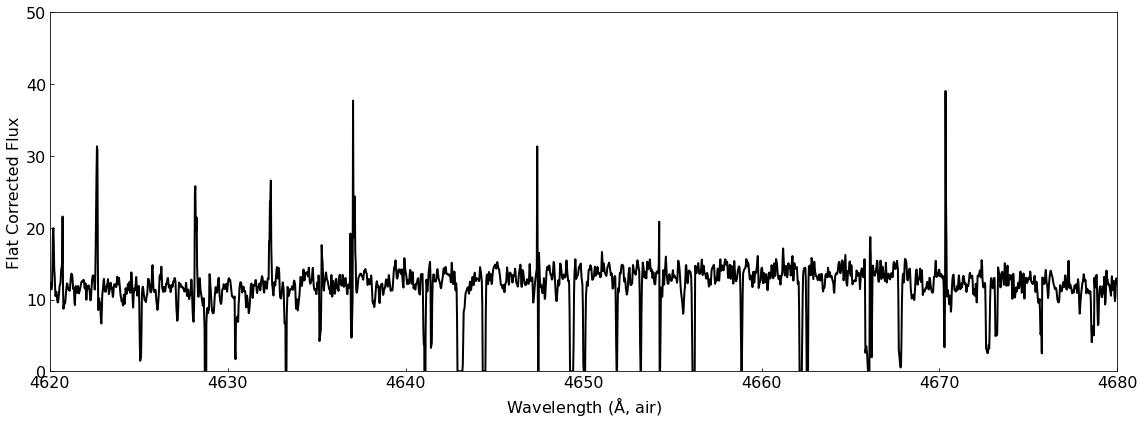

In [10]:
snrplot(star_wave_blue, star_blue_arr, star_blue_var_arr, xrange=[4620, 4680], yrange=[0,50], extension=1)


# Plot combined spectrum and variance

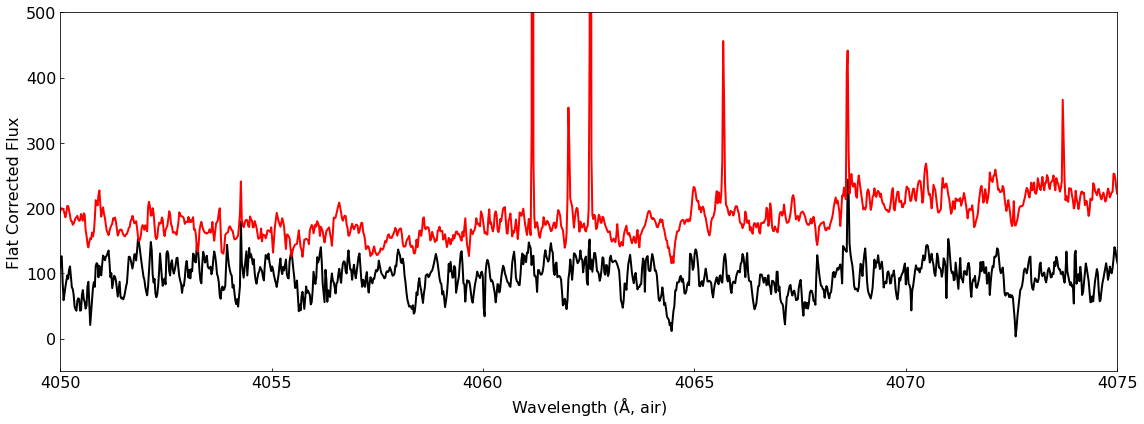

In [60]:
datavarplot(star_blue_wave_comb, star_blue_comb, star_blue_var_comb, xrange=[4050, 4075], 
            yrange=[-50, 500], extension=None)

# Plot combined spectrum S/N

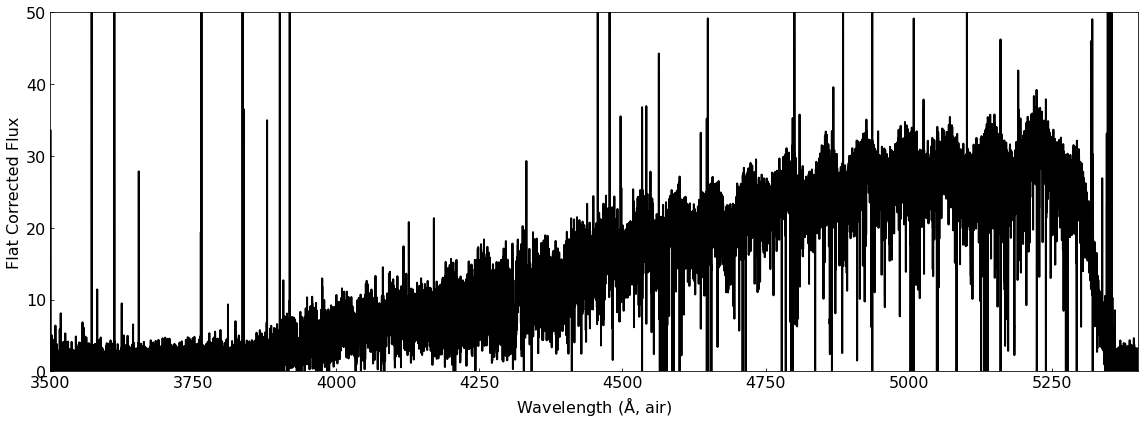

In [49]:
snrplot(star_blue_wave_comb, star_blue_comb, star_blue_var_comb, xrange=[3500, 5400], yrange=[0,50], extension=None)

# Plot a median filtered S/N of the combined spectrum (smoothed by a "size" of N pixels)

<ipython-input-51-bfdc64f21f70>:9: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(x, median_filter(y, size=size)/np.sqrt(median_filter(var, size=size)), c='k', lw=2, label='snr')


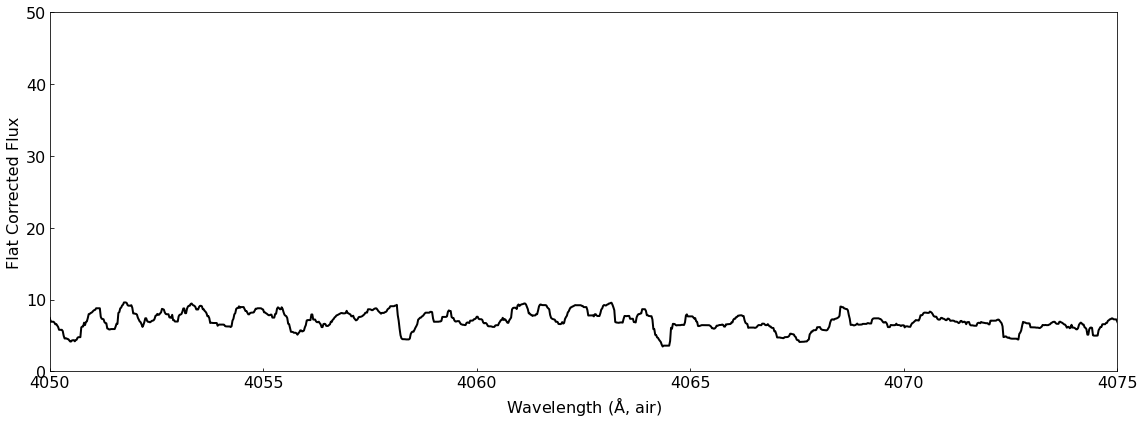

In [61]:
medfil_snrplot(star_blue_wave_comb, star_blue_comb, star_blue_var_comb, xrange=[4050, 4075], yrange=[0,50], extension=None, size=15)